# Instructions

1. Add your name and HW Group Number below.
2. Complete each question. Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and delete and `throw NotImplementedError()` lines.
3. Where applicable, run the test cases *below* each question to check your work. **Note**: In addition to the test cases you can see, the instructor may run additional test cases, including using *other datasets* to validate you code.
4. Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). You can also use the **Validate** button to run all test cases.
5. Submit your homework on Moodle.



In [1]:
"""
Name: Amit Prakash
HW Group Number: 5
"""
your_ncsu_gmail = "aprakas5@ncsu.edu"

# **Problem 2 Knn & Adaboost**

In this part, you'll be working with KNN and AdaBoost.

# 0) Loading Data & Libraries

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets

# set a seed for reproducibility
random_seed = 25
np.random.seed(random_seed)

# We need to ignore FutureWarnings due to a bug in our version of sklearn
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# 1) Twitter Sentiment Analysis using KNN

[Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is the study of how we can systematically identify and quantify sentiment of a given segment of text. In this problem, you will be using the [Sentiment140](http://help.sentiment140.com/for-students/) dataset to build a classifier that will rate the sentiment of a string of text on a scale from 0 to 4.

**WARNING:** This is *real* data from *real* people from Twitter. That means you might (and probably will) see some unscrupulous language when browsing the dataset. Don't browse with kids around!

Let's take a look at our data, and what attributes we have.

* **polarity**: The assumed polarity of the tweet. For this subset, we're only considering positive and negative tweets, no neutrality.
* **id**: The tweet ID.
* **date**: The date the tweet was posted.
* **query**: The search term used in order to find tweets of a certain topic.
* **text**: The actual text of the tweet.

For now, we only consider the **polarity** and **text** attributes.

In [3]:
train_data = pd.read_csv('/home/jupyter-{}/hw2_p3.csv'.format(your_ncsu_gmail))
train_data.head()

,Unnamed: 0,polarity,id,date,query,user,text
0,639736,0,1881528306,Fri May 22 04:54:30 PDT 2009,NO_QUERY,ClareMacG,where is he? hmmmm he didnt even reply to me t...
1,228095,0,1759081303,Sun May 10 18:25:07 PDT 2009,NO_QUERY,jaredhaha,family guy sucks tonight
2,689126,0,2322274292,Wed Jun 24 22:20:07 PDT 2009,NO_QUERY,spazzyyarn,"@jesus_iscomin I am so sorry, that sucks!"
3,372153,0,1693569517,Sun May 03 22:59:23 PDT 2009,NO_QUERY,missprettylady,goin to bed...definitly didn't study like i wa...
4,365761,0,2244313762,Fri Jun 19 14:35:02 PDT 2009,NO_QUERY,jojoe777,"just was at the hospital, long story made shor..."


In [4]:
# Check our disribution of polarity
# 4 means postive sentiment
# 0 means negative sentiment
train_data.polarity.value_counts()

0    20000
4    20000
Name: polarity, dtype: int64

## 1.1) Example: Brief Introduction to tf-idf

Read through and run the following example, and answer the question at the end.

In information retreival [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (*term frequency – inverse document frequency*) is a metric that represents how "important" a word is to a corpus of text. While we won't go into detail about how it works, essentially all you need to know is that it balances two metrics.

**Term Frequency**: Is exactly what one would expect, it is the the frequency at which a word is present in a corpus of text. A word with a higher term-frequency score appears much more in the corpus compared to one with a low term frequency.

**Inverse Document Frequency**: If we only used term frequency, common words like "the" or "and" would have a high score, even though they don't give us that much information since they are present in every document. *Inverse Document Frequency* is a metric of how much "information" a word provides, and if a word is common or rare across all documents.

### tf-idf with sklearn

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?'
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.shape)

(4, 9)


The tf-idf vectorizer's `fit_transform` method returns a NxM matrix. `N` is the number of documents (sentences) you have in your corpus, and `M` is the number of unique words in your corpus. Item `n`x`m` is how important word `m` is to document `n`.

In [6]:
# Printing out the tf-idf matrix
np.set_printoptions(precision=4)
print(X.toarray())

[[0.     0.4698 0.5803 0.3841 0.     0.     0.3841 0.     0.3841]
 [0.     0.6876 0.     0.2811 0.     0.5386 0.2811 0.     0.2811]
 [0.5118 0.     0.     0.2671 0.5118 0.     0.2671 0.5118 0.2671]
 [0.     0.4698 0.5803 0.3841 0.     0.     0.3841 0.     0.3841]]


In [7]:
# Notice that if we try and print X directly, we get an overview saying that X is a "sparse matrix".
# In very large corpi with many unique words, a lot of row entries are going to consist of majority zeros
# Thus numpy saves theses in a special compressed sparse format
X

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [8]:
# Next let's see what word each column corresponds to:
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

Let's look at the tf-idf vectors for two different documents.

**Note**: `dic(zip(A, B))` in pyton makes a dictionary out of a list of keys (A) and values (B). This just makes it easier to view each term with it's corresponding TFIDF value.

In [9]:
print(corpus[0])
dict(zip(vectorizer.get_feature_names_out(),X.toarray()[0]))

This is the first document.


{'and': 0.0,
 'document': 0.46979138557992045,
 'first': 0.5802858236844359,
 'is': 0.38408524091481483,
 'one': 0.0,
 'second': 0.0,
 'the': 0.38408524091481483,
 'third': 0.0,
 'this': 0.38408524091481483}

In [10]:
print(corpus[1])
dict(zip(vectorizer.get_feature_names_out(),X.toarray()[1]))

This document is the second document.


{'and': 0.0,
 'document': 0.6876235979836938,
 'first': 0.0,
 'is': 0.281088674033753,
 'one': 0.0,
 'second': 0.5386476208856763,
 'the': 0.281088674033753,
 'third': 0.0,
 'this': 0.281088674033753}

Take a look at the tf-idf vectors for both of these sentences and answer the following questions:
1. Why is the value for the term "is" higher in document1 than document2?
2. Why is the value for the term "document" higher in document2 than document1?

1. The value for the term "is" is higher in document1 since there are less words in document1 as opposed to document2, so "is" would be more important in document1 as opposed to document2.
2. The value for the term "document" is higher in document2 since "document" appears more frequently in document2.

## 1.2) tf-idf on Twitter

Now, before we build a classifier, let's just try and see what the nearest neighbors of a specified message are.

In [11]:
# Get our text
corpus = train_data["text"]

In [12]:
# Run our transform
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(corpus)

In [13]:
# Let's check the size of our matrix
tfidf_matrix

<40000x50209 sparse matrix of type '<class 'numpy.float64'>'
	with 476467 stored elements in Compressed Sparse Row format>

Now, let's fit the nearest neighbors tree! Please use [NearestNeighbors](https://scikit-learn.org/stable/modules/neighbors.html) from sklearn library

NOTE: fit the nearest neighbors tree (with **five** neighbors) on _**"tfidf_matrx"**_ we got from above, and return the model as _**"nbrs"**_

In [17]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors = 5, algorithm = 'ball_tree').fit(tfidf_matrix)

In [18]:
assert(nbrs.n_features_in_ == 50209)
assert(nbrs.n_samples_fit_ == 40000)
assert(nbrs.get_params()['n_neighbors'] == 5)

We can now run custom sentences and see what sentences in the corpus are "closest" to what we put in. Try a few and see what shows up! In addition to this, you can change the `n_neighbors` param and get more queries.

In [19]:
test_docs = ["I sure love paying my taxes!"]
test_docs = tf.transform(test_docs)
distances, indicies = nbrs.kneighbors(test_docs)
train_data.iloc[indicies[0]]

,Unnamed: 0,polarity,id,date,query,user,text
10068,617716,0,2265303137,Sun Jun 21 06:16:29 PDT 2009,NO_QUERY,beesjebinda,Doing our taxes
123,658220,0,2062031962,Sat Jun 06 22:10:14 PDT 2009,NO_QUERY,kaylabranch,can't spend ANY MONEY TOMORROW... except payin...
5528,141336,0,2008866840,Tue Jun 02 14:46:56 PDT 2009,NO_QUERY,wintertime88,"@CounterfeitGent Haha, I couldn't possibly dud..."
15132,564636,0,2288415211,Mon Jun 22 19:07:58 PDT 2009,NO_QUERY,AKWilliams87,paying bills while my roomates are at the movi...
38438,78508,4,1962781884,Fri May 29 11:39:17 PDT 2009,NO_QUERY,thecaribgem,"@AYOSONNYBROWN Awww, so u r paying attention...."


In [20]:
# As a bonus, show our distances
print(distances)

[[0.9768 1.1163 1.2237 1.2367 1.2439]]


Now investigate:
1. Try manually classifying the tweet "Wow, this is so cool!" What are the classes of the neighbors? How would a 5-NN classifier classify that tweet?
2. Can you think of a tweet that might fool this classifier? For example, how would it do with sarcasm?

In [21]:
test_docs = ["Wow, this is so cool!"]
test_docs = tf.transform(test_docs)
distances, indicies = nbrs.kneighbors(test_docs)
train_data.iloc[indicies[0]]

,Unnamed: 0,polarity,id,date,query,user,text
3996,139202,0,2002966578,Tue Jun 02 05:35:13 PDT 2009,NO_QUERY,Tifanei,wow....
3000,374176,0,2224215495,Thu Jun 18 09:13:44 PDT 2009,NO_QUERY,i_love_gerard,wow. this is ugly. im bored
15514,403840,0,2216046658,Wed Jun 17 18:58:12 PDT 2009,NO_QUERY,Havalilly,"wow, i can't believe how much i'm still actual..."
25297,467823,4,1565071153,Mon Apr 20 05:48:55 PDT 2009,NO_QUERY,preranapradhan,only 3 days to go this week...wow
35952,662408,4,2055336383,Sat Jun 06 09:07:52 PDT 2009,NO_QUERY,gatewood2010,wow. i'm a newbie at this.


1. "Wow, this is so cool!" would be classified under Tifanei, i_love_gerard, Havalilly, preranapradhan, and gatewood2010.
2. Any sarcastic or joking tweet might be misclassified under this classifier since the KNN would take anything in the tweet literally. 

We will continue working witht this dataset in hw2-p3!

# 2) AdaBoost

In this exercise, you'll be learning how to use [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), as well as vizualize decision boundries.

## 2.1) Exmple: Decision Tree Baseline

In [22]:
# Read the iris dataset and translate to pandas dataframe
bc_sk = datasets.load_breast_cancer()
# Note that the "target" attribute is species, represented as an integer
bc_data = pd.DataFrame(data= np.c_[bc_sk['data'], bc_sk['target']],columns= list(bc_sk['feature_names'])+['target'])

In [23]:
from sklearn.model_selection import train_test_split
# The fraction of data that will be test data
test_data_fraction = 0.10

bc_features = bc_data.iloc[:,0:-1]
bc_labels = bc_data["target"]
X_train, X_test, Y_train, Y_test = train_test_split(bc_features, bc_labels, test_size=test_data_fraction,  random_state=random_seed)

First, let's have a baseline non-boosted decision tree to compare against.

In [24]:
from sklearn.tree import DecisionTreeClassifier
gini_tree = DecisionTreeClassifier(criterion = "gini", random_state=random_seed).fit(X=X_train, y=Y_train)

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
predicted_y = gini_tree.predict(X_test)

In [26]:
print(classification_report(predicted_y,Y_test))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        20
         1.0       0.92      0.92      0.92        37

    accuracy                           0.89        57
   macro avg       0.88      0.88      0.88        57
weighted avg       0.89      0.89      0.89        57



In [27]:
confusion_matrix(predicted_y,Y_test)

array([[17,  3],
       [ 3, 34]])

## 2.2: Adaboost Classifier

Now, let's get boosting with the [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). The default estimator for AdaBoost is a *decision stump*. (Remember: a decision stump is simply a decision tree with a height of 1).

* The `n_estimators` parameter is the number of base models in the ensemble.

In [44]:
# YOUR CODE HERE
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(n_estimators = 40, random_state = random_seed).fit(X_train, Y_train)

In [45]:
from sklearn.metrics import accuracy_score
np.testing.assert_almost_equal(accuracy_score(ada_model.predict(X_test), Y_test), 0.9473684210526315)

In [46]:
predicted_y = ada_model.predict(X_test)

In [47]:
print(classification_report(predicted_y,Y_test))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92        19
         1.0       0.97      0.95      0.96        38

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



In [48]:
confusion_matrix(predicted_y,Y_test)

array([[18,  1],
       [ 2, 36]])

As we can see, the boosted model performs better than a full decision tree, even though it only uses some decision stumps. In the next section, we'll explore why that is.

## 2.3) CSC522 Only: Visualizing Decision Boundries

**Note**: This problem is only required for 522 students; it is extra credit for 422 students.

Now, we're going to peek under the hood and see the decision boundries of ensemble learners. To do so, we'll implement our own version of ada boost.

In [49]:
from sklearn.datasets import make_moons

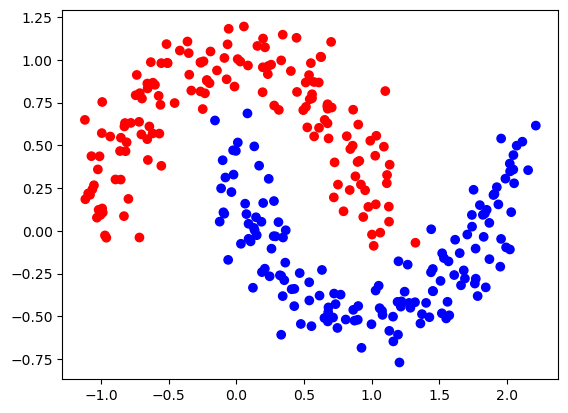

In [50]:
# A nice noisy dataset that's not linearly separable
X,y = make_moons(300, noise=0.13,random_state = random_seed)
colors = {0:'red',1:"blue"}
plt.scatter(X[:,0],X[:,1],c=np.vectorize(colors.get)(y))

### 2.3.1: Clculating Alpha

**Note**: This problem is only required for 522 students; it is extra credit for 422 students.

You're given some code to calculate Adaboost by hand below, but for it to work, you need to complete the following helper functions.

In `calculate_alpha`, you should calculate alpha for the round, based on the classifier's predictions and the weights of that round. The basic steps are:
1. Calculate the **weighted** error $\epsilon$ for the round by comparing those predictions to y. Remember, the error is the sum of the weights of misclassified instances.
2. Calculate alpha using the following formula:

$$\alpha = 0.5*ln(\frac{1 - \epsilon}{\epsilon})$$

In [ ]:
import math
def calculate_alpha(predictions, weights, y):
    """
    Inputs:
        predictions: the predictions (0 or 1) of the classifier in this round.
        weights: the weights of each instance at the end of last round
        y: the class labels (0 or 1) for the instances
    Output: the alpha value for this round
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# To test calculate_alpha, we need to make a decision tree and some starting weights
dt = DecisionTreeClassifier(criterion = "gini", max_depth=1, random_state=123).fit(X, y)
predictions = dt.predict(X)
weights = np.repeat(1 / len(X), len(X))
# Alpha should be ~0.84
alpha = calculate_alpha(predictions, weights, y)

In [ ]:
np.testing.assert_almost_equal(alpha, 0.8416209435087314)

### 2.3.2: Updating Weights

**Note**: This problem is only required for 522 students; it is extra credit for 422 students.

Next you need to write a function that will update the weights for the adaboost classifier based on the alpha value. Remember:
* Correctly classified instances have their weight decreased.
* Incorrectly classified instances have their weight increased.

The amount by which the weight changes is $e^\alpha$.

**Note**: You do not need to normalize the weights to sum to 1 - the code below will do that for you.

In [ ]:
import math
def update_weights(predictions, weights, y, alpha):
    """
    Inputs:
        predictions: the predictions (0 or 1) of the classifier in this round.
        weights: the weights at the end of the previous round for each instance
        y: the class labels (0 or 1) for the instances
        alpha: the alpha value for this round
    Output: an array of updated weights for this round
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Initialize the weights to 1 / n
weights = np.repeat(1 / len(X), len(X))
alpha = calculate_alpha(predictions, weights, y)
# Do one round of updating
new_weights = update_weights(predictions, weights, y, alpha) 
# See how the weights have changed for each instance - some increased, some decreased
print(new_weights)

In [ ]:
weights = np.repeat(1 / len(X), len(X))
# Do one round of updating
new_weights = update_weights(predictions, weights, y, alpha) 
alpha = 0.8416209435087314
np.testing.assert_almost_equal(max(new_weights), 1/300*math.exp(alpha))
np.testing.assert_almost_equal(min(new_weights), 1/300/math.exp(alpha))

### 2.3.3 Example: Adaboost Iteration

**Note**: This problem is only required for 522 students; it is extra credit for 422 students.

Here's our code for Adaboost. You don't have to modify it, just finish the functions above, and then answer the free-response question at the end.

Why are we implementing it by hand? This way we can keep track of which samples were chosen each round to visualize them.

When you run the following code, you can see the alpha values for each round, changing as the weights, and therefore the samples, change.

In [ ]:
# Let's do 20 rounds of adaboost
rounds = 20
# N is the length of training data
N = len(X)
# Each boostrapped sample will b size N/5
sample_size = N // 5

# Each round, keep track of:
# Which instances (indices) were samples
sample_indices = []
# The classifier built on that sample
dtrees = []
# The alpha value for each that round
alphas = []

# Start our weights off each as 1/N
weights = np.repeat(1 / N, N)

for i in range(rounds):
    indices = np.random.choice(range(N), sample_size, replace=True, p=weights)
    sample_X = X[indices,:]
    sample_y = y[indices]
    # Train a simple decision tree on the sample
    dt = DecisionTreeClassifier(criterion = "gini", max_depth=1).fit(sample_X, sample_y)
    predictions = dt.predict(X)
    
    # Calculate alpha
    alpha = calculate_alpha(predictions, weights, y)
    print(f'Round {i} Alpha: {alpha}')
    
    # Update weights
    weights = update_weights(predictions, weights, y, alpha)
    weights /= sum(weights)
    
    sample_indices.append(indices)
    alphas.append(alpha)
    dtrees.append(dt)

In [ ]:
# This function makes predictions for a given list of X features by taking the weighted sum of
# its constituent classifiers' predictions.
def boosting_predict(X_test):
    return np.mean([(dtrees[i].predict(X_test) - 0.5) * alphas[i] for i in range(len(dtrees))], axis=0) + 0.5

In [ ]:
# Based on the image above, how should points (0, 0) and (1, 1) be classified?
# Note that the output is continuous: > 0.5 means more likely to be 1.
boosting_predict([[0, 0], [0, 1]])

The following code will plot the predictions from individual rounds of adaboost. Note:
* The background color indicates the prediction.
* The faded dots were *not* sampled in this round (e.g. because of their low weights).

In [ ]:
# Here is a provided method that will plot the decision boundries of each stump

def plot_predictions(pred_function, sample_indices, subplot=plt, continuous=False):
    plot_colors = "br"
    plot_step = 0.02
    class_names = "AB"

    #

    # Plot the decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = pred_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if not continuous:
        Z = np.round(Z)
        cs = subplot.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    else:
        cs = subplot.contourf(xx, yy, Z)

    # Plot the training points
    for i, n, c in zip(range(2), class_names, plot_colors):
        idx = np.where(y == i)
        in_sample_idx = np.intersect1d(idx, sample_indices)
        subplot.scatter(X[in_sample_idx, 0], X[in_sample_idx, 1],
                    c=c, cmap=plt.cm.Paired,
                    s=20, edgecolor='k',
                    label="Class %s (Sampled)" % n)
        out_sample_idx = np.setdiff1d(idx, in_sample_idx)
        subplot.scatter(X[out_sample_idx, 0], X[out_sample_idx, 1],
                    c=c, cmap=plt.cm.Paired,
                    s=20, edgecolor='k', alpha=0.1,
                    label="Class %s (Not Sampled)" % n)


Now we plot the first 12 rounds of adaboost:

In [ ]:
rows = 4
cols = 3

figure, axis = plt.subplots(rows, cols, figsize=(15, 10))
figure.tight_layout()

for i in range(rows):
    for j in range(cols):
        idx = i*rows + j
        subplot = plot_predictions(dtrees[idx].predict, sample_indices[idx], axis[i,j])
        axis[i,j].title.set_text(f'Round {idx}: Alpha = {alphas[idx]}')

plt.show()

Now answer the following questions:
1. Which rounds are most important to the classification? What do they have in common?
2. Do you notice any changes in the samples (and resulting classifiers) in later rounds of Adaboost?

YOUR ANSWER HERE

Finally, we can plot the whole adaboost classifier. Note the non-linear decision boundary.
* The first plot shows the discrete boundary, comprised of all of the above weak classifiers.
* The second plot shows the same prediction as a continuous boundary.

In [ ]:
plot_predictions(boosting_predict, range(len(X)), plt)

In [ ]:
plot_predictions(boosting_predict, range(len(X)), plt, continuous=True)

Now answer the following questions:
1. How can Adaboost create a non-linear boundary to accurately classify this shape?
2. Which areas of the plot is the classifier most certain about, or least certain?

YOUR ANSWER HERE

**Remember**: Make sure to complete all problems (.ipynb files) in this assignment. When you finish, double-check the submission instructions at the top of this file, and submit on JupyterHub.